![Photo from Los Angeles Times](image/eaton.jpeg)

More information for this project can be found on the [GitHub Repository](https://github.com/kylienewcomer/eds220-hwk4.git)

## About
In 2025, the Los Angeles area experienced two massive fires perpetuated by stong Santa Ana winds and dry brush. Though on opposite sides of the county, the Eaton and Palisades fires burned almost in unison and primarily impacted Altadena near Pasadena and Palisades near Malibu. As a result, over 16,000 homes and businesses were destroyed and 31 lives were lost (stat from Los Angeles County). The fires lasted 24 days, however both communities are still rebuilding after the tragedy. This project visualizes the aftermath and burn scars of the Palisades and Eaton fires with satellite images and geospatial data.

### Highlights:
- Work with and visualize raster data using `xarray` and `NetCDF` datasets
- Analyze false color images with satellite imagery by using different reflectance wavelengths
- Visualize raster and geographic data together to determine areas with fire scars
- Examine socioeconomic demographics of areas affected by the fires


## Import necessary packages
We start by importing `geopandas` and `xarray` which are necessary reading geopsatial data. We will also use `matplotlib.pyplot` for visualization.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import xarray as xr
import matplotlib.pyplot as plt

## Fire perimeter data and exploration
We use known fire perimeter data for the Palisades and Eaton fires from the ArcGIS hub.

Before we start working with the data, it's important to understand what the data actually looks like and represents. The fire perimeter data is imported and explored to understand the type of data and approaches for visualization. We will look at the CRS and data types in each column.

In [2]:
# Read in Palisades perimeter data
fp = os.path.join('data/Palisades_perm_20250121/Palisades_Perimeter_20250121.shp')
pal_perm = gpd.read_file(fp)

# Read in Eaton perimeter data
fp = os.path.join('data/Eaton_perm_20250121/Eaton_Perimeter_20250121.shp')
eat_perm = gpd.read_file(fp)


In [3]:
# Look at CRS of perimeter datasets
print('Palisades perimeter CRS:', pal_perm.crs)
print('Eaton perimeter CRS:', eat_perm.crs)

Palisades perimeter CRS: EPSG:3857
Eaton perimeter CRS: EPSG:3857


In [4]:
# Look at column types
print('Palisades perimeter dtypes:\n', pal_perm.dtypes)

Palisades perimeter dtypes:
 OBJECTID         int64
type            object
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object


In [5]:
print('Eaton perimeter dtypes:\n', eat_perm.dtypes)

Eaton perimeter dtypes:
 OBJECTID         int64
type            object
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object


Through exploration, it was determined that both perimeters have a projection of EPSG:3857. Both datasets are fairly similar, only containing spatial data in both numeric and geometric types.

## Landsat data and exploration with NetCDF
To actually visualize the fire scars, we utilized reflectance satellite imagery of the Los Angeles area following the fires. This data comes from Microsof Planetary Computer data catalogue and was collected by the Earth Resources Observation and Science (EROS) Center. This data is multi-dimensional, containing a collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat 8 satellite.

The landsat data is analyzed using the Network Common Data Form (NetCDF). 
NetCDF data is imported and explored to determine the ways it can be visualized and paired with the perimeter datasets. We explore the data in a similar way to the perimeter data, 

In [6]:
landsat = xr.open_dataset('data/landsat8-2025-02-23-palisades-eaton.nc')

In [7]:
landsat.head()

<xarray.Dataset> Size: 596B
Dimensions:      (y: 5, x: 5)
Coordinates:
  * y            (y) float64 40B 3.799e+06 3.799e+06 ... 3.799e+06 3.799e+06
  * x            (x) float64 40B 3.344e+05 3.344e+05 ... 3.345e+05 3.345e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 100B ...
    green        (y, x) float32 100B ...
    blue         (y, x) float32 100B ...
    nir08        (y, x) float32 100B ...
    swir22       (y, x) float32 100B ...
    spatial_ref  int64 8B ...

The `landsat` dataset is 3-dimensional with x and y geographic dimensions and the third being time. The data has six variables, `red`, `green`, `blue`, `nir08`, `swir22`, `spatial_ref`, 5 of which measure different waves of light reflectance.

## Restoring geospatial information
Upon exploration, we determined that the landsat data is not a geospatial object. Using `NetCDF` with data does not present geospatial in the same way as we would expect from `geopandas` dataframes. In order to work with both the `landsat` data and the perimeter data, we need to standarized the geographic projections to visualize the data together. This can be done by accessing the spatial reference variable to determine the projection.

In [8]:
# Use `spatial_ref.crs_wkt` to access spatial reference variable
landsat_crs = landsat.spatial_ref.crs_wkt

# Assign CRS as previously accessed spatial reference variable
landsat = landsat.rio.write_crs(landsat_crs)


print(f'The CRS of the landsat data is {landsat.rio.crs}')

The CRS of the landsat data is EPSG:32611


We need to determine if there are any NA's in any of the band variables. 


In [9]:

for band in landsat.data_vars:
    print(band, landsat[band].isnull().any().item())

red False
green True
blue True
nir08 False
swir22 False


In [10]:
landsat = landsat.fillna(0)

## False color map with fire perimeters
A false colored image displaying inrafred and near infrared false color images with the fire perimeters is created. In this image there is a clear distinction of vegetation and other land coverage between places that did and did not experience fires.

In [11]:
# Need to fix CRS's of perimeters
pal_perm = pal_perm.to_crs(landsat_crs)
eat_perm = eat_perm.to_crs(landsat_crs)

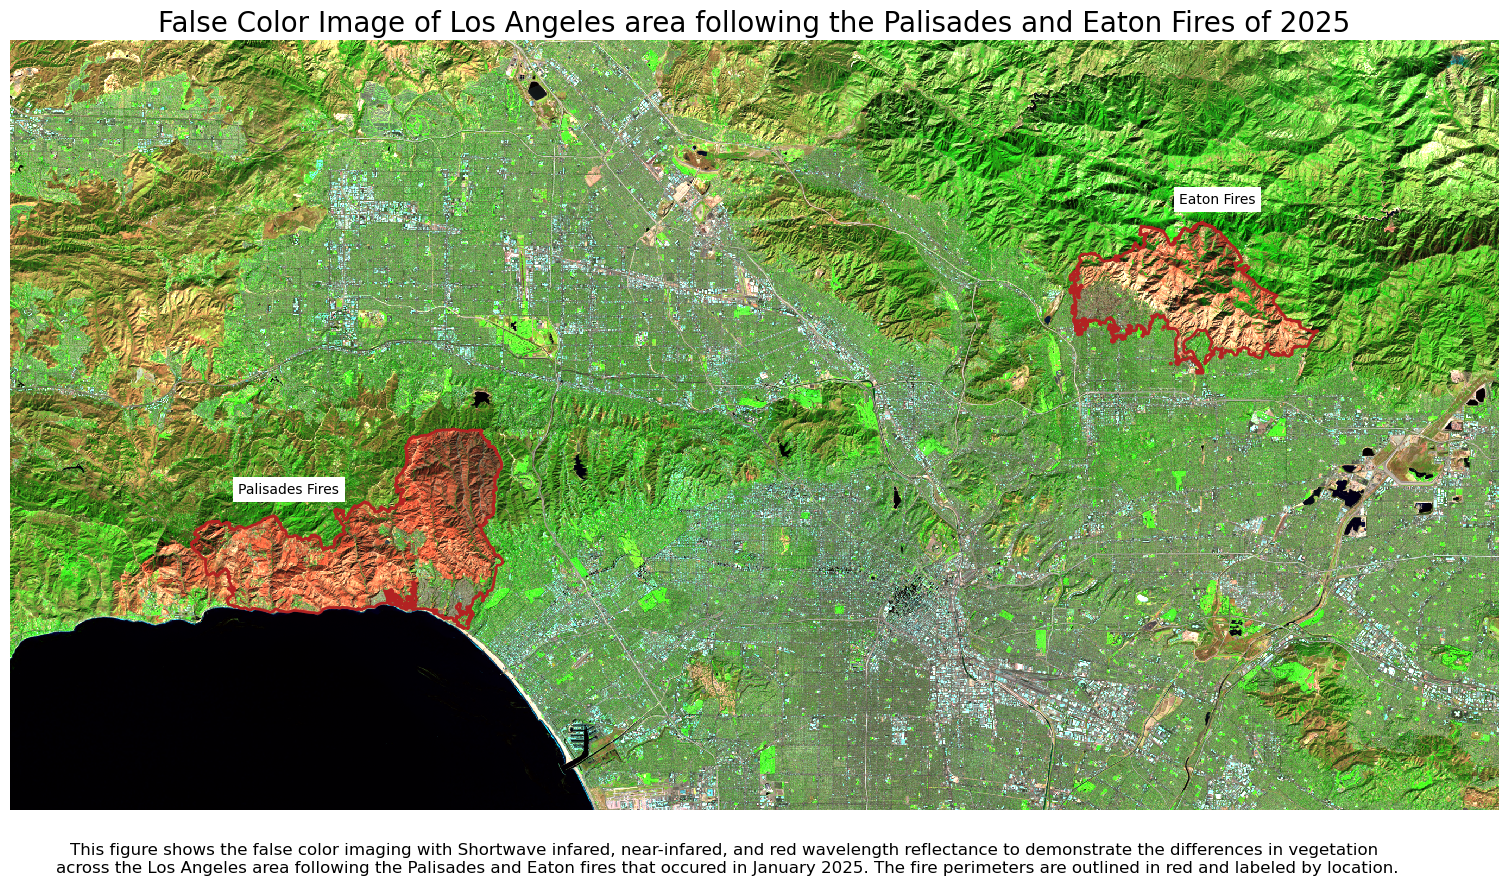

In [12]:
fig, (ax) = plt.subplots( figsize=(22, 10))

# Plot false color image
landsat[[ "swir22", "nir08", "red"]].to_array().plot.imshow(robust = True, ax=ax)
plt.title('False Color Image of Los Angeles area following the Palisades and Eaton Fires of 2025', size = 20)

# Plot Eaton and Palisades perimeters
eat_perm.plot(ax=ax, edgecolor = "firebrick", linewidth = 2, color = "none")
pal_perm.plot(ax=ax, edgecolor = "firebrick", linewidth = 2, color = "none")

# Make the aesthetically nicer
ax.axis('off')

# Add labels for fires
ax.text(x = 399000, y = 3790000, s = "Eaton Fires", color = "black", fontsize = 10).set_bbox(dict(facecolor='white', edgecolor = 'none'))
ax.text(x = 347000, y = 3774000, s = "Palisades Fires", color = "black", fontsize = 10).set_bbox(dict(facecolor='white', edgecolor = 'none'))

# Add a description of the figure
plt.figtext(s = "This figure shows the false color imaging with Shortwave infared, near-infared, and red wavelength reflectance to demonstrate the differences in vegetation \nacross the Los Angeles area following the Palisades and Eaton fires that occured in January 2025. The fire perimeters are outlined in red and labeled by location.",
            x = 0.5,
            y = 0.05,
            ha = 'center',
            size = 12,
            wrap = True)
    
plt.show()

## Import and analyze environmental justice data
We use the Environmental Justice Index (EJI) from Centers for Disease Control and Prevention and Agency for Toxic Substances Disease Registry to visualize the socioeconmic demographics within the fire perimeters. 

To use the EJI data with the fire perimeter data, the projections must be transformed to combine and visualize the data

In [13]:
eji = gpd.read_file("data/EJI_2024_United_States/EJI_2024_United_States.gdb")

In [14]:
eji.columns = eji.columns.str.lower()

eat_perm = eat_perm.to_crs(eji.crs)

pal_perm = pal_perm.to_crs(eji.crs)

eji_eat = gpd.clip(eji, eat_perm)

eji_pal = gpd.clip(eji, pal_perm)

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


## Create an image of uninsured homes within fire perimeters

We are interested in analyzing socioeconomic demographics of the homes in the fire perimeters. With such extreme damage to many homes in the fires, looking at the amount of uninsured homes within the fire perimeters will represent how deterimental these fires were to so many homes.

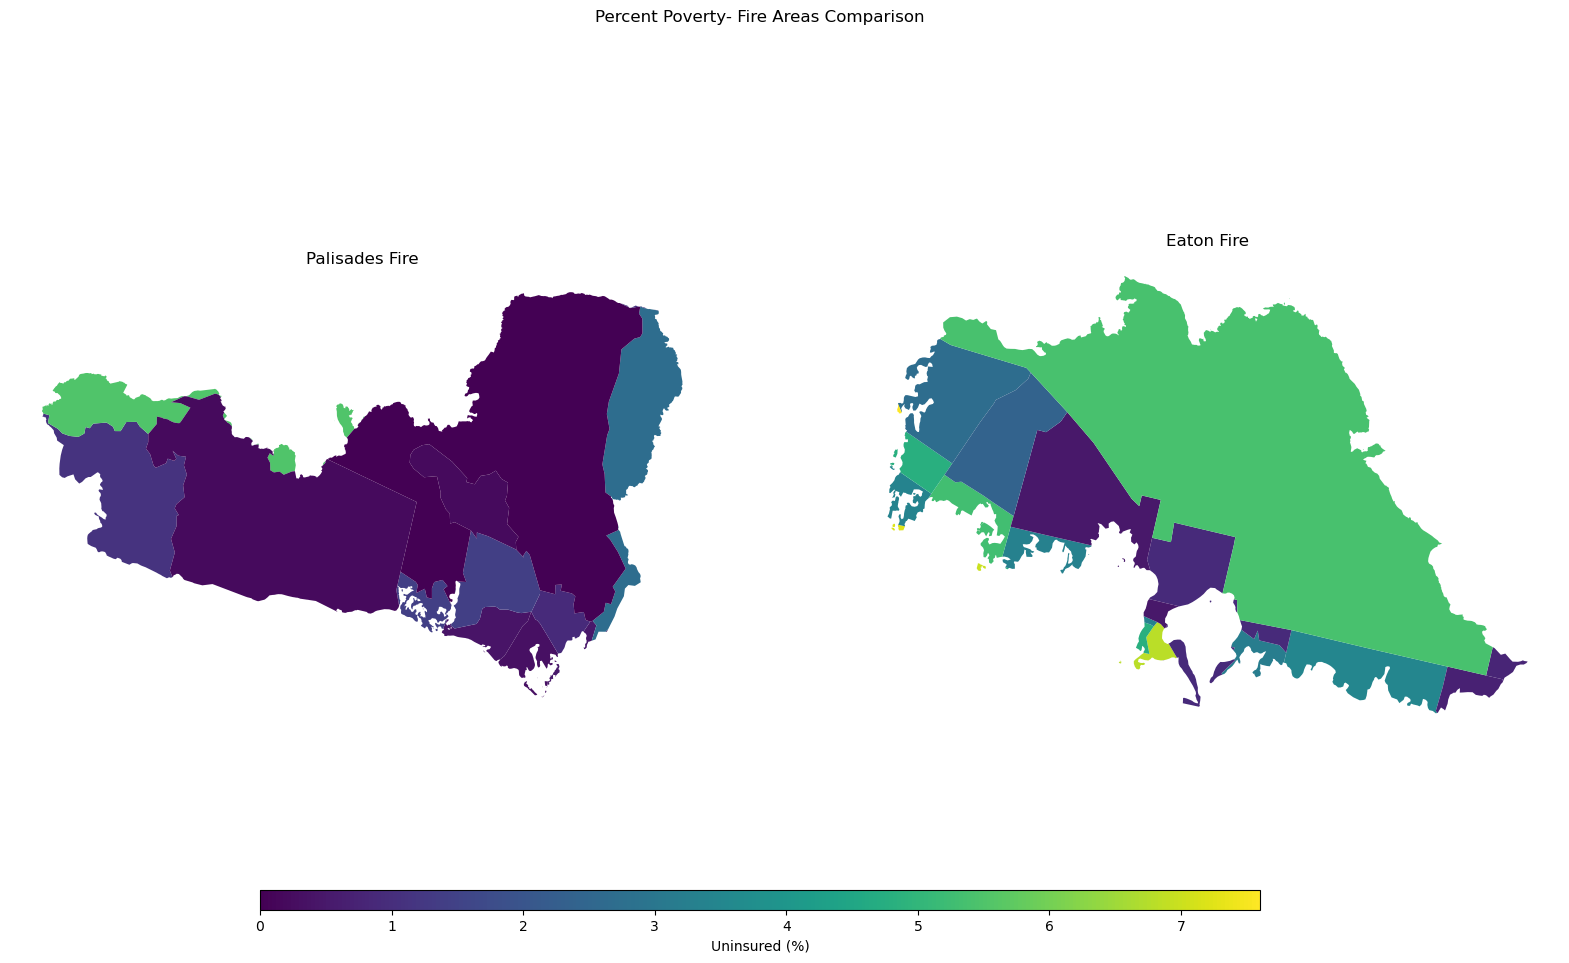

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# UPDATE WITH YOU EJI VARIABLE FROM STEP 1
eji_variable = 'e_uninsur'

# Find common min/max for legend range
vmin = min(eji_pal[eji_variable].min(), eji_eat[eji_variable].min())
vmax = max(eji_pal[eji_variable].max(), eji_eat[eji_variable].max())

# Plot census tracts within Palisades perimeter
eji_pal.plot(
    column= eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
)
ax1.set_title('Palisades Fire')
ax1.axis('off')

# Plot census tracts within Eaton perimeter
eji_eat.plot(
    column= eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
)
ax2.set_title('Eaton Fire')
ax2.axis('off')

# Add overall title
fig.suptitle('Percent Poverty- Fire Areas Comparison')

# Add shared colorbar at the bottom
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Uninsured (%)')

plt.show()

## Conclusion
The Eaton and Palisades fires swept across many communities resulting in extreme damage. Through false color imagery, we visualized the burn scars in relation to the known perimeters of the fires. The percentage of uninsured homes across the Eaton fires was much greater than the percent of homes in the Palisades fires, with some areas reaching 7% of uninsured homes.

## References:
Centers for Disease Control and Prevention and Agency for Toxic Substances Disease Registry. [Year] Environmental Justice Index. Accessed [Dec. 3, 2025]. https://atsdr.cdc.gov/place-health/php/eji/eji-data-download.html

Earth Resources Observation and Science (EROS) Center. (2020). Landsat 8–9 Operational Land Imager / Thermal Infrared Sensor Level-2, Collection 2 [Dataset]. U.S. Geological Survey. https://doi.org/10.5066/P9OGBGM6 [Accessed Nov. 22 2025]

Los Angeles County Enterprise GIS. (2025). Palisades and Eaton Dissolved Fire Perimeters [Dataset]. Los Angeles County. https://egis-lacounty.hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about [Accessed Nov. 22 2025]